# **Simple Neural Network From Scratch**

Hey guys, today I'm going to walk you through building a simple neural network from scratch. If you're new to this, don't worry - **No prior knowledge required**. If this is your first step into the world of AI, welcome :) If you already know a bit about the field, I hope this document will deepen your understanding of the mechanisms behind neural networks.

Today we will be training a model to identify and classify handwritten digits using the MNIST dataset. This is a very famous dataset in machine learning. It consists of 60,000 labelled images of handwritten digits 0 to 9. We are going to train a model to correctly label digits as it sees them, with over 90% accuracy! Are you ready? Let's begin!

## **Firstly, what is a neural network?**

A neural network is exactly what is says on the tin: It's a *network* of *neurons*. 

A neuron in this context, is essentially a function. It takes a numerical input, applies some operations to it, and spits out a numerical output. For a simple neuron, there are 3 parameters to consider:
- Weights (W)
- Bias (b)
- Activation Function (f)

Let's look at each in turn.

**Weights**
The "weights" are scalar numbers we multiply our inputs by to scale them in some way. We initialise them pseudo-randomly, and the machine will learn to optimise them as it goes along (more on that later). The weights essentially emphasise the more important inputs and minimise the effect of less important ones.

**Bias**
The bias controls how "trigger happy" the neuron is. Changing the bias will affect how "biased" our neuron is towards high or low activation values.

**Activation Function**
This function "squishes" the output between a certain range, to transform our output and make it more useful for the next stage. Common activation funcitons between layers are **sigmoid**, which squishes all values between $[0,1]$ and **ReLU**, which makes all values $\geq 0$

A neural network is then just a network comprised of "layers" of these neurons. At each layer, the output from the previous layer is passed forward as input to the next layer. We can have as many layers and as many neurons per layer as our heart desires. However, having too few will make your model inaccurate and less adept at learning (imagine if you had too few neurons in your brain, you'd probably find it pretty hard to learn), while having too many will make your model more difficult and time consuming to train. 

Right, now that you know what a neural network is, let's get to building one!

## **The Program**

We will only be using these 3 python libraries for this project. If you're not familiar with them, numpy gives us basic maths & linear algebra functionality, pandas allows us to read and setup dataframes, and matplotlib allows us to graph and display our images

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Data Preparation**
Here we load in our dataset (available on my github, as well as a thousand places online). 

We first load it as a pandas dataframe then immediately convert it into a 60000 x 785 numpy array. The first column is the label of the image, and the next 784 columns are the pixel values for a 28 x 28 image. There are then 60000 rows for 60000 images + labels.

We randomly shuffle the data before splitting it into training and test data. The training data is used to train the model, and the test data is used to check our performance afterwards. We will use a 90/10 split for training and test data.

We set y as our labels and x as our pixel values, and we normalise the x values to be between 0 and 1

In [36]:
#set seed for reproducability
np.random.seed(42)

#load data
filepath = "C://Users//Dylan//Desktop//Coding//CSVs//MNIST.csv" #insert your filepath here if running it yourself
data = pd.read_csv(filepath)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

#define the ratio to split the data
ratio = 0.9
index = int(len(data) * ratio)

#split data into training and testing using this ratio
testData = data[0:6000].T
trainData = data[6000:m].T

#split each into features(x) and labels(y) and normalise the x features
yTest = testData[0]
xTest = testData[1:n]/255
yTrain = trainData[0]
xTrain = trainData[1:n]/255

## **Neural Network Structure**
This will be quite a simple network. We will have:
- an input layer of 784 neurons (one for each pixel value)
- an output layer of 10 neurons (one for each label)
- two hidden layers of 32 neurons (where the magic happens).

The number of neurons in the hidden layers was chosen completely arbitrarily: I just happen to like the number 32. Feel free to mess around with different numbers of neurons to see how it affects the performance of the model.

## **Visualizing the Data**
It's no fun training an image classification model if we don't get to see the images it's classifying! Let's take a look now at some of the images from our dataset so we can see what we're dealing with. I don't know about you, but I think I would struggle with classifying some of these!

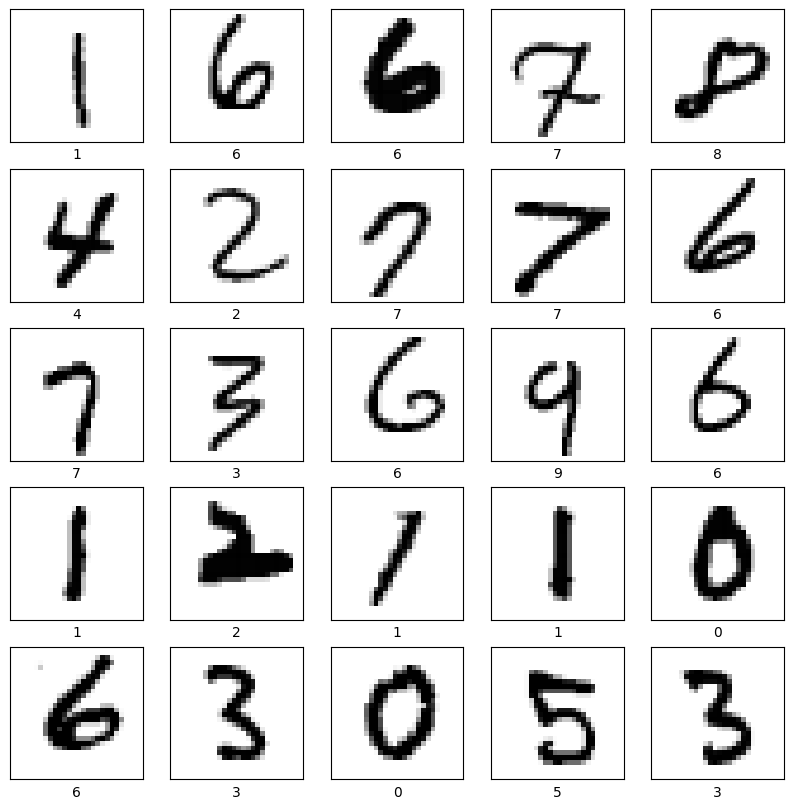

In [37]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]);
    plt.yticks([]);
    plt.grid(False);
    plt.imshow(xTrain[:,i, None].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(yTrain[i])

plt.show()

As we mentioned before, a neural network is essentially a composition of layers of "functions", where in each neuron the activations from the previous layer are scaled by some weight and a bias is added. Then the whole output is squished through an activation funciton and sent off to the next layer. Before we begin training the model, we must initialise these weights, biases and activation functions:

In [38]:
#Initializes weights and biases for a simple 2-layer neural network.
#Weights are initialised with random values between -0.5 and 0.5.

def initialParameters():
    
    # Initialize weights and biases for the first layer (32 neurons, 784 inputs)
    W1 = np.random.rand(32, 784) - 0.5
    b1 = np.random.rand(32, 1) - 0.5

    # Initialize weights and biases for the second layer (10 neurons, 32 inputs)
    W2 = np.random.rand(10, 32) - 0.5
    b2 = np.random.rand(10, 1) - 0.5

    return W1, b1, W2, b2

#Define f(z) as the ReLU function
def f(z):
    
    return np.maximum(0,z)

#Define the derivative of f with respect to z (will come in handy later)
def f_prime(z):
    
    return z > 0

#Define the softmax funciton, which will turn z into a vector of probailities
def softmax(z):
    
    expZ = np.exp(z - np.max(z)) #Normailise by subtracting max(z) from each z_i for numerical stability
    softmax = expZ/np.sum(expZ,axis=0)
    
    return softmax

## **Forward Propagation**
The first step in training a model is the forward propagation pass. Essentially, this is just feeding an image into the network, and having the info pass all the way through, layer by later until the end. The steps involved in this are:
- Calculating the weighted sum of the inputs (plus bias) at each layer: $Z^{l} = W^{l} \cdot A^{l-1} + b^{l}$
- Feeding this into our activation function f to get the next activations: $A^{l} = f(Z^{l})$
- Rinse and repeat until you hit the output layer, then you're done :)

This is a pretty simple mechanism for feeding the data forward. For our specific model, we will have two hidden layers using the weights, biases and activation functions that we defined above. Let's take a look more explicitly at them:

- **First Layer:** Here our activation function $f()$ is ReLU (Rectified Linear Unit), which scales all inputs to values $\geq 0$
- **Second Layer:** Here our activation function is $softmax(z_i) := \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$. Softmax turns our output layer into a vector of probablities, so our output layer can be read as the model's predictions of how likely it thinks this image is to be each number. We then extract its guess as the number it gave the highest probability.

Here's an implementation of forward propagation as a function in python:

In [39]:
def forwardPropagation(W1, b1, W2, b2, X):    
    
    #First layer calculations
    Z1 = np.dot(W1, X) + b1
    A1 = f(Z1)

    #Second layer calculations
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

## **Backpropagation & Gradient Descent**
Since we initialised the weights at random, our output from the forward pass is nothing more than a terrible guess. We need some way to adjust these weights and biases, to "train" the model and improve its predictions. That's where backpropagation comes in!

### **Backpropagation**
Backpropagation is the way by which this network will actually "learn". It's an algorithm for iteratively updating the weights and biases after each forward pass, to tweak the network a bit and produce more and more accurate predictions. More technically, backpropagation is an autodifferentiation method that calculates the gradient (slope) of the loss function with respect to the weights and biases. It then updates each parameter by subtracting this gradient, scaled by a learning rate $\alpha$

Taking a step back, what we are essentially trying to do through backpropagation is, once we have made our guess through the forward pass, we want to see how small changes in each weight and bias would affect our output, and identify which weights and biases are the most important for us to change. Which ones will give us the most bang for our buck. We'll look at the explicit steps in a minute when we write our code for it.

### **Loss Function**
How will we do this? Firstly we define a "loss function", which will quantify how good or bad our current prediction is. A high loss value means we are way off, and a low one means we are quite accurate. There are many options for loss functions, two common ones for classification tasks such as this are:
- **Mean Squared Error**: $\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$
- **Cross Entropy:** $-\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$

These both involve transforming our labels y into a **binary** or **one-hot** vector. It is called this as it is a vector of all zeros, except for one 1 in the entry corresponding with the correct label. (For example, the two entry for <2, 4, 6> would become <0,1,0,0,0,0>). This is very useful for us in calculating our loss functions.

### **Gradient Descent**
Gradient descent is a method for minimising loss functions. Our objective is to be as accurate as possible, so we want our loss to be as low as possible. We do this by calculating the gradient of the cost function using backpropagation, then updating all the parameters by subtracting their corresponding gradient, scaled by a "learning rate" $\alpha$. This learning rate affects, you guessed it, the rate at which our network learns. More specifically, it controls how big a "step" we take each time we update our parameters.

You can imagine gradient descent as a person walking down a foggy hill. The hight of the hill is our loss, so we want to get as far down the hill as possible, but we can't see very far so we don't have enough information to set a straight path to the lowest valley. We have to do this iteratively, one step at a time, to update our information as we go. Gradient descent calculates the direction we should take our next step to go down the hill as efficiently as possible, and the learning rate determines how big a step we take.

Here is an implementation of gradient descent backpropagation in code:

First we define a binary encoding function that will turn Y into a vector of integer labels (6,2,4,...) into a binary or "one hot" vector (0,0,1,0,...). It is called "one hot" as there is one 1 in the entry corresponding to the correct number, and zeros elsewhere. This will be useful in defining our loss function later.

In [40]:
def binaryEncode(labels):
   
    n = len(labels)
    nUnique = len(np.unique(labels)) #number of unique labels (in this case 0-9 so 10)
    binaryEncode = np.zeros((nUnique, n)) #10 x n matrix of zeros
    binaryEncode[labels, np.arange(n)] = 1 #adds a 1 to the corresponding entry for each label
    
    return binaryEncode

Now, it's time to put backpropagation into practice. For our specific model here, the steps in backpropagation are as follows:

- **Compute the Loss:** Here we pick our loss function, which will tell us how wrong our predictions are. For this model, we will use **Cross Entropy:** $-\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$, as its derivative will simplify very nicely and make life easy for us later.

- **Backpropagate the Error:** For each layer starting from the output layer and working back, calculate the gradient of the loss function with respect to the weights & biases for this layer, and activations from the previous layer:
    - The gradient of the loss with respect to the weights $dW^{l}$: $dW^{l} = \frac{1}{m} dZ^{l} \cdot A^{l-1\,T}$
    - The gradient of the loss with respect to the biases $db^{l}$: $db^{l} = \frac{1}{m} \sum dZ^{l}$
    - The error for the previous layer $dZ^{l-1}$: $dZ^{l-1} = W^{l\,T} \cdot dZ^{l} * f'(Z^{l-1})$

    This tells us how much a nudge to each weight or bias would affect the loss
    
    Here, $m$ is the number of training examples, $*$ denotes element-wise multiplication, and $f'(Z^{l-1})$ is the derivative of the activation function with respect to $Z^{l-1}$.

- **Update the Parameters:** Now that we've calculated the gradients, we can update our parameters and take a step downhill:
    - Update weights: $W^{l} = W^{l} - \alpha \times dW^{l}$
    - Update biases: $b^{l} = b^{l} - \alpha \times db^{l}$


- **Rinse and Repeat:** We keep doing this over and over as the model gradually improves and "learns". We can either run this algorithm for a fixed time (say 500 steps) or until our loss is below a desired threshold. However if you pick a very low threshold, it may take a long time for the model to reach it, or it in fact may never reach it, so we will be using a fixed time.

I hope that clarifies the steps of backpropagation and gradient descent somewhat. Now let's see it working in code!

In [41]:

def backProp(Z1, A1, A2, W2, X, Y, m):
   
    #binary encode the y vector
    binaryY = binaryEncode(Y)

    #Layer 2 gradients
    dZ2 = A2 - binaryY
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2).reshape(-1,1) / m

    #Layer 1 gradients
    dZ1 = np.dot(W2.T, dZ2) * f_prime(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1).reshape(-1,1) / m

    return dW1, db1, dW2, db2

Now that we've calculated these derivatives, we can update our parameters accordingly. For each parameter, our new update is the previous parameter value, minus the corresponding gradient times a learning rate, which controls how big a "jump" we take.


In [42]:
def updateParameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    
    W1 = W1 - alpha*dW1
    b1 = b1 - alpha*db1
    W2 = W2 - alpha*dW2
    b2 = b2 - alpha*db2

    return W1, b1, W2, b2

## Training the Network

Now that we've defined all our functions and algoirthms, let's get to the juicy part: training the model! In the code below, we call all the functions we defined above to train our model using gradient descent for 500 loops. This number was picked through experimentation to see when we converge to a decent accuracy level. Feel free to change the number of iterations or the learning rate to see if you can get better accuracy!

In [43]:
#this just returns the the entry the model gave the highest probability of being correct from its softmax output
def predictions(A2):
    return np.argmax(A2,0)

#this defines accuracy simply as the percentage of images that it classified correctly
def accuracy(predictions, labels):
    return np.mean(predictions == labels)

#here is our function for training the model
def trainModel(X, Y, alpha, iterations):
    
    #set initial parameters
    W1, b1, W2, b2 = initialParameters()
    
    #iterate through forward and backward propagation, updating parameters through gradient descent
    for i in range(iterations):
        Z1, A1, Z2, A2 = forwardPropagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backProp(Z1, A1, A2, W2, X, Y, X.shape[1])
        W1, b1, W2, b2 = updateParameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            pred = predictions(A2)
            acc = accuracy(pred, Y)
            print(f"Iteration: {i}, Accuracy: {acc}")

    return W1, b1, W2, b2

W1, b1, W2, b2 = trainModel(xTrain, yTrain, 0.3, 500)

Iteration: 0, Accuracy: 0.067
Iteration: 10, Accuracy: 0.5451481481481482
Iteration: 20, Accuracy: 0.6737962962962963
Iteration: 30, Accuracy: 0.7343888888888889
Iteration: 40, Accuracy: 0.7701851851851852
Iteration: 50, Accuracy: 0.7916111111111112
Iteration: 60, Accuracy: 0.7611111111111111
Iteration: 70, Accuracy: 0.8149814814814815
Iteration: 80, Accuracy: 0.8273148148148148
Iteration: 90, Accuracy: 0.8328518518518518
Iteration: 100, Accuracy: 0.8350925925925926
Iteration: 110, Accuracy: 0.8459629629629629
Iteration: 120, Accuracy: 0.8541481481481481
Iteration: 130, Accuracy: 0.8597962962962963
Iteration: 140, Accuracy: 0.8636481481481482
Iteration: 150, Accuracy: 0.8658518518518519
Iteration: 160, Accuracy: 0.8681296296296296
Iteration: 170, Accuracy: 0.8709259259259259
Iteration: 180, Accuracy: 0.8754259259259259
Iteration: 190, Accuracy: 0.8791111111111111
Iteration: 200, Accuracy: 0.881962962962963
Iteration: 210, Accuracy: 0.8841296296296296
Iteration: 220, Accuracy: 0.8865185

Watching the accuracy improve as the model learns can be very interesting. Notice how on it's first pass it was 8% accurate, yet 10 iterations later it's already up to 50%. Then it reaches 80% accuracy after 60 iterations, but doesn't hit 90% till 310 iterations! Our model is approximately 91% accurate on the training data. That's not too shabby. State of the art models can reach 99.7% accuracy, but they use a few tricks that we may cover in future tutorials. For such a simple model, 91% is quite good.

## Testing the Model
Now that we've trained the model, we need to test it using the data we put aside at the start. This is a crucial step as it allows us to gauge how well the model performs on images it has never seen before. We don't want a model that works really well on its training data but is useless on new images. That is called overfitting, and we want to avoid that as much as possible. So, let's see how well our model has learned, shall we?

In [44]:
def makePredictions(W1, b1, W2, b2, X):
    #takes the last layer from our network and makes predictions from it
    A2 = forwardPropagation(W1, b1, W2, b2, X)[3]
    
    return predictions(A2)

testPred = makePredictions(W1, b1, W2, b2, xTest)
acc = accuracy(testPred, yTest)
print(f"Test Accuracy: {acc}")

Test Accuracy: 0.9153333333333333


Test accuracy of over 90%, our model is a success! It generalised very well from the training data and can correctly classify new, unseen images with over 90% accuracy!

Now, let's take a look at some of the numbers our model got wrong. This can give us an insight into what patterns the model may be picking up on

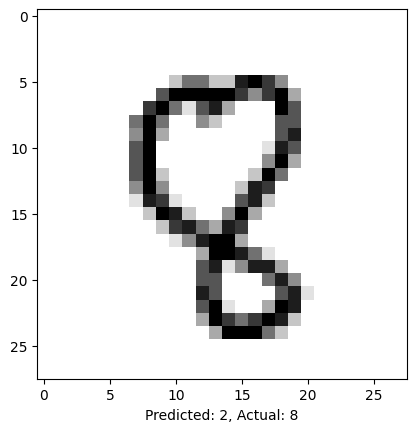

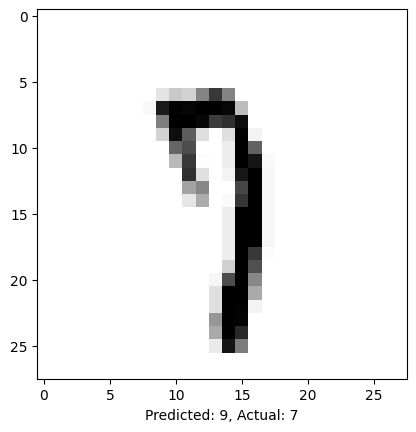

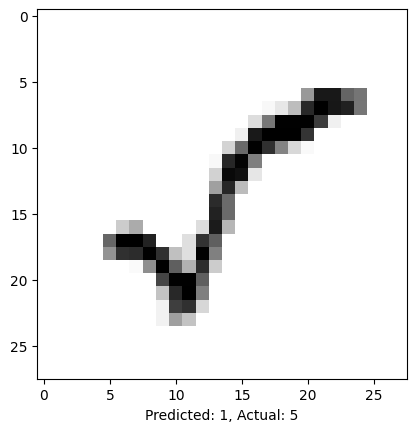

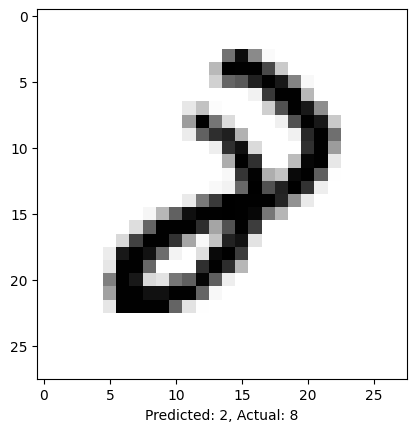

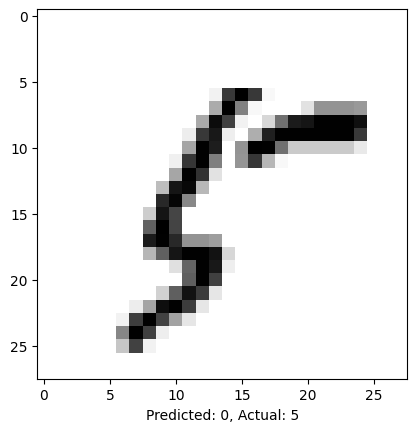

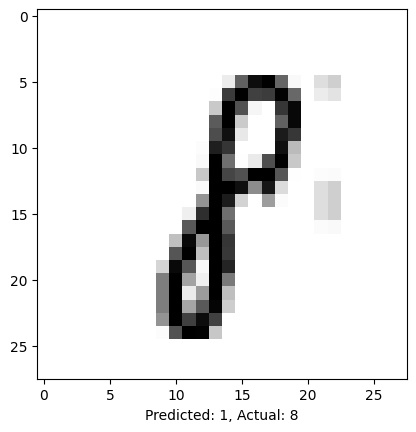

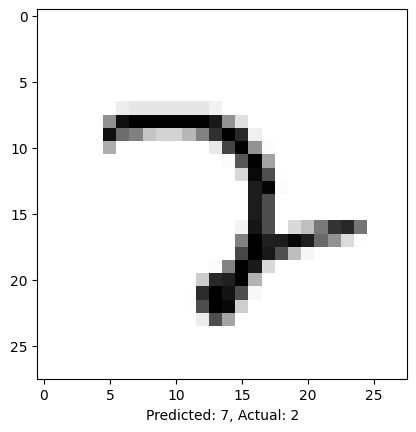

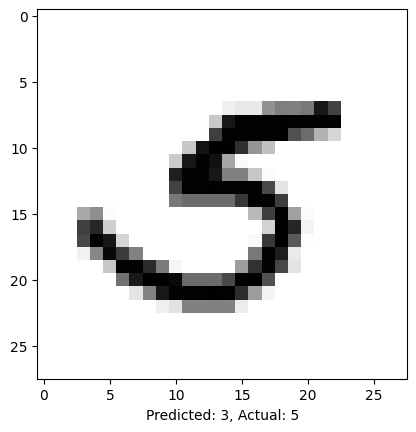

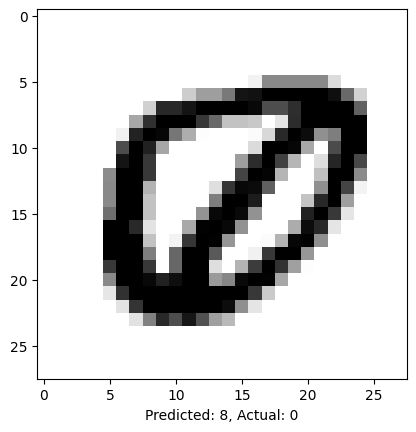

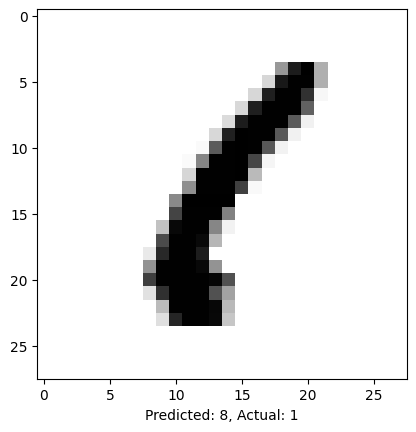

In [45]:
def incorrect(testPred, yTest, xTest):
    #finds all the incorrectly classified images
    incorrect = testPred != yTest

    return xTest[:, incorrect]

#gets the image data for each incorrectly predicted image
incorrect_images = incorrect(testPred, yTest, xTest)
#gets the guess the model incorrectly predicted
incorrect_preds = testPred[testPred != yTest]

#prints the first 10 incorrect images with the correct label alongside the incorrect guess
for i in range(10):
    plt.gray()
    plt.imshow(incorrect_images[:, i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(f"Predicted: {incorrect_preds[i]}, Actual: {yTest[testPred != yTest][i]}")
    plt.show()

Looking at some of the ones our bot misclassified, I almost feel bad for it. I'm not sure I would have gotten some of those correct either!

So, that's that! We successfully built a bot from scratch that can recognise handwritten digits with over 90% accuracy! I hope you enjoyed our little experiment today, and I hope you've learned something interesting. Now you can tell all your friends you know how to build a neural network from scratch!

If you enjoyed this and thought it was cool, I highly recommend you go through the code and mess with some of the parameters to get a better feel for how it works. Perhaps try adding another layer to see if it improves the accuracy. Can you get it to 95% accuracy?